BNO frames: 8896
BNO rotation mats shape: (8896, 3, 3)
H5 files: [PosixPath('/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13/MIR_Aligned/aligned_predictions_with_ca_and_dF_F_wnd1000_stp700_max15_diff3.5_pnrauto.h5')]
Predicted frames: 8896
Head rotation mats shape: (8896, 3, 3)
Frame 0 pred pts:
 [[ -3.71953889 -14.63203413   0.59609063]
 [  3.71953889  14.63203413  -0.59609063]
 [ 21.25044992   2.63730421 -20.55993497]]
Frame 0 bno pts:
 [[ -3.60296932 -12.7264707    7.30357939]
 [  3.60296932  12.7264707   -7.30357939]
 [  0.89323715  -6.64324364 -28.91915233]]


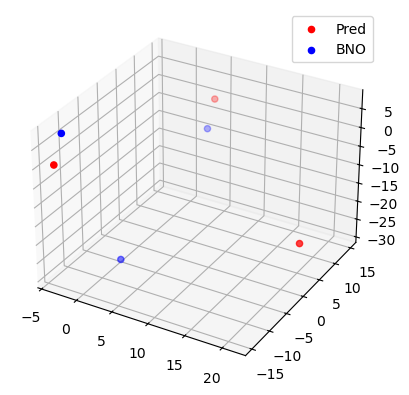

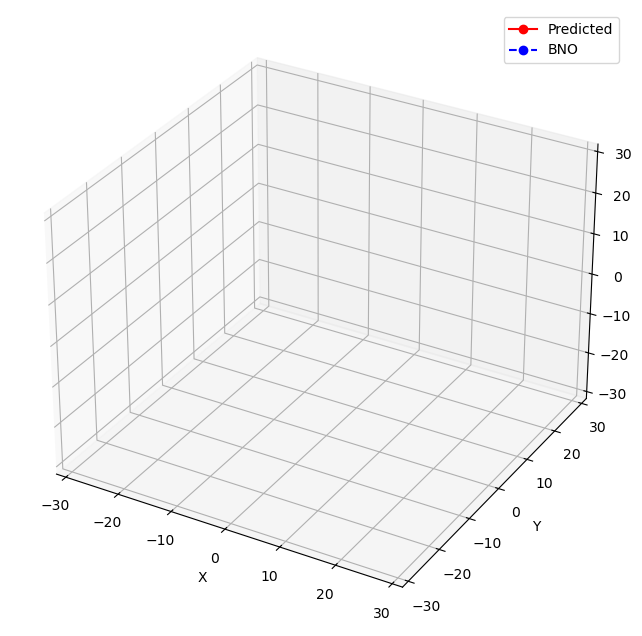

In [2]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from pathlib import Path

# --- Load filtered BNO data ---
bno_csv = "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13/MIR_Aligned/headOrientation_filtered.csv"
df_bno = pd.read_csv(bno_csv).rename(columns={'Time Stamp (ms)': 'time_ms'})
times = df_bno['time_ms'].to_numpy()
quats = df_bno[['qx','qy','qz','qw']].to_numpy()
rots = R.from_quat(quats)
bno_mats = rots.as_matrix()

print(f"BNO frames: {len(times)}")
print(f"BNO rotation mats shape: {bno_mats.shape}")

# --- Load prediction H5 and compute head frames ---
base_path = "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13"
aligned_dir = Path(base_path) / 'MIR_Aligned'
h5_paths = list(aligned_dir.glob('aligned_predictions_with_ca_and_dF_F_*.h5'))
if not h5_paths:
    raise FileNotFoundError(f"No .h5 files found in {aligned_dir}")
print("H5 files:", h5_paths)

df_pred = pd.read_hdf(str(h5_paths[0]), key='df')
print(f"Predicted frames: {len(df_pred)}")

# --- Compute head rotation matrices ---
def normalize(v):
    n = np.linalg.norm(v, axis=1, keepdims=True)
    return np.where(n < 1e-8, v, v / n)

R_heads = []
for _, row in df_pred.iterrows():
    earL  = row[['kp1_x','kp1_y','kp1_z']].to_numpy()
    earR  = row[['kp2_x','kp2_y','kp2_z']].to_numpy()
    snout = row[['kp3_x','kp3_y','kp3_z']].to_numpy()

    mid = (earL + earR) / 2.0
    x = normalize((snout - mid).reshape(1,3))[0]
    temp = (earR - earL).reshape(1,3)
    y = normalize((temp - np.dot(temp, x) * x).reshape(1,3))[0]
    z = np.cross(x, y)
    z = z / (np.linalg.norm(z) + 1e-8)
    R_heads.append(np.column_stack((x, y, z)))

R_heads = np.stack(R_heads)
print(f"Head rotation mats shape: {R_heads.shape}")

assert R_heads.shape == bno_mats.shape, \
    f"Frame mismatch: pred {R_heads.shape[0]}, bno {bno_mats.shape[0]}"

# --- Precompute relative rotations (correct order) ---
R0_bno = bno_mats[0]
R_bno_rel = np.einsum('ij,nkj->nki', np.linalg.inv(R0_bno), bno_mats)
R0_pred = R_heads[0]
R_pred_rel = np.einsum('ij,nkj->nki', np.linalg.inv(R0_pred), R_heads)

# --- Initial triangle vertices (relative) ---
earL0 = df_pred.iloc[0][['kp1_x','kp1_y','kp1_z']].to_numpy()
earR0 = df_pred.iloc[0][['kp2_x','kp2_y','kp2_z']].to_numpy()
sn0   = df_pred.iloc[0][['kp3_x','kp3_y','kp3_z']].to_numpy()
mid0  = (earL0 + earR0) / 2.0
verts0 = np.vstack([earL0-mid0, earR0-mid0, sn0-mid0])

# --- Frame 0 sanity check ---
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p0 = verts0 @ R_pred_rel[0].T
b0 = verts0 @ R_bno_rel[0].T
print("Frame 0 pred pts:\n", p0)
print("Frame 0 bno pts:\n", b0)
ax.scatter(p0[:,0], p0[:,1], p0[:,2], c='r', label='Pred')
ax.scatter(b0[:,0], b0[:,1], b0[:,2], c='b', label='BNO')
ax.legend()
plt.show()

# --- Determine plot limits dynamically based on initial frame ---
all0 = np.vstack([p0, b0])
lim = np.max(np.abs(all0)) * 1.1

# --- Set up animation ---
fig2 = plt.figure(figsize=(8,8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)
ax2.set_zlim(-lim, lim)
ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')
pred_line, = ax2.plot([], [], [], 'r-o', label='Predicted')
bno_line,  = ax2.plot([], [], [], 'b--o', label='BNO')
ax2.legend()

def update(i):
    p_pts = verts0 @ R_pred_rel[i].T
    b_pts = verts0 @ R_bno_rel[i].T

    pred_line.set_data(p_pts[:,0], p_pts[:,1])
    pred_line.set_3d_properties(p_pts[:,2])

    bno_line.set_data(b_pts[:,0], b_pts[:,1])
    bno_line.set_3d_properties(b_pts[:,2])

    ax2.set_title(f"t = {times[i]} ms")
    return pred_line, bno_line

# ani = FuncAnimation(fig2, update, frames=len(times), interval=50, blit=False)

# --- Save animation (mp4, fallback to GIF) ---
# output_mp4 = "pred_bno_test_orientation_anim.mp4"
# try:
#     ani.save(output_mp4, writer='ffmpeg', fps=10)
#     print("Saved animation to", output_mp4)
# except Exception as e:
#     print("ffmpeg save failed:", e)
#     try:
#         output_gif = "pred_bno_test_orientation_anim.gif"
#         ani.save(output_gif, writer='pillow', fps=10)
#         print("Saved animation to", output_gif)
#     except Exception as e2:
#         print("Pillow save failed:", e2)


Error °: mean=53.08, median=50.84, std=14.92
Saved orientation_error.csv


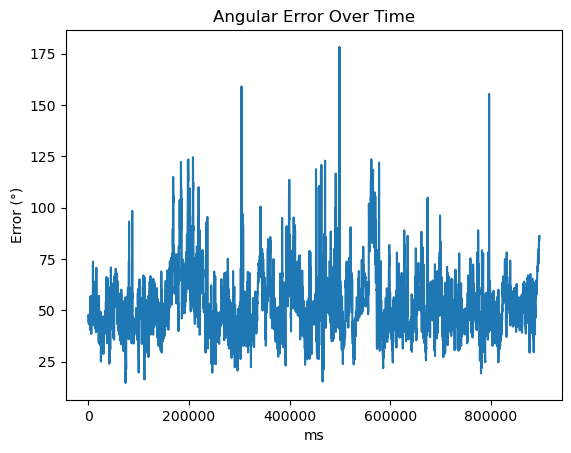

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def rotation_error(R_ref, R_est):
    R_err = np.einsum('nij,njk->nik', R_ref.transpose(0,2,1), R_est)
    ang   = np.arccos(np.clip((np.trace(R_err,axis1=1,axis2=2)-1)/2, -1,1))
    return np.degrees(ang)

# compute error
degs = rotation_error(R_bno_rel, R_pred_rel)
print(f"Error °: mean={degs.mean():.2f}, median={np.median(degs):.2f}, std={degs.std():.2f}")

# save + plot
eval_df = pd.DataFrame({'time_ms':times,'error_deg':degs})
# eval_df.to_csv('orientation_error.csv',index=False)
# print('Saved orientation_error.csv')

plt.figure(); plt.plot(times,degs); plt.xlabel('ms'); plt.ylabel('Error (°)'); plt.title('Angular Error Over Time'); plt.show()

Snout-vector angle error (°): mean=44.851, median=43.684, std=13.958


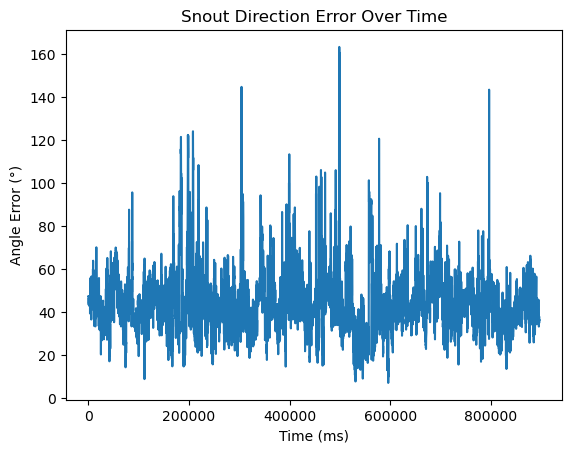

Mean vertex distance: mean=12.7060, median=12.3056, std=3.7736


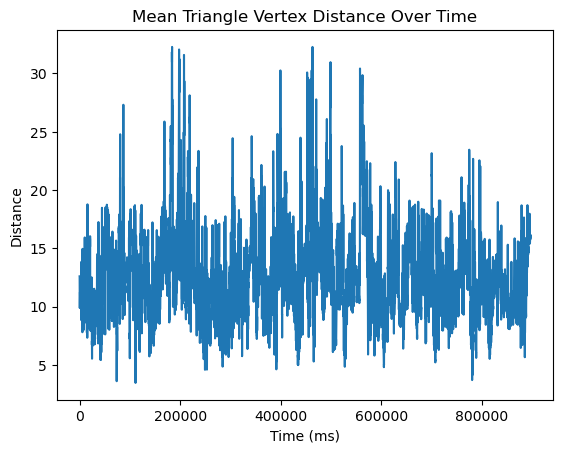

In [4]:
# Cell 3: Alternative evaluation metrics (run after Cell 2)
# --- Snout forward-vector angle error ---
# initial forward vector (snout minus mid)
init_vec = (sn0 - mid0) / np.linalg.norm(sn0 - mid0)
# apply relative rotations
t_pred = np.einsum('nij,j->ni', R_pred_rel, init_vec)
t_bno  = np.einsum('nij,j->ni', R_bno_rel, init_vec)
# compute angle error
dots = np.sum(t_pred * t_bno, axis=1)
ang_err_vec = np.degrees(np.arccos(np.clip(dots, -1, 1)))
print(f"Snout-vector angle error (°): mean={np.mean(ang_err_vec):.3f}, median={np.median(ang_err_vec):.3f}, std={np.std(ang_err_vec):.3f}")
# save and plot
# pd.DataFrame({'time_ms': times, 'fwd_vector_angle_err': ang_err_vec}).to_csv('forward_angle_error.csv', index=False)
plt.figure(); plt.plot(times, ang_err_vec); plt.xlabel('Time (ms)'); plt.ylabel('Angle Error (°)'); plt.title('Snout Direction Error Over Time'); plt.show()

# --- Mean Euclidean distance between triangle vertices ---
# Transform initial verts by each relative rotation
d_pred = np.einsum('kj,nij->nki', verts0, R_pred_rel)
d_bno  = np.einsum('kj,nij->nki', verts0, R_bno_rel)
# compute per-frame vertex distances
v_dist = np.linalg.norm(d_pred - d_bno, axis=2)
mean_pt_dist = np.mean(v_dist, axis=1)
print(f"Mean vertex distance: mean={np.mean(mean_pt_dist):.4f}, median={np.median(mean_pt_dist):.4f}, std={np.std(mean_pt_dist):.4f}")
# save and plot
# pd.DataFrame({'time_ms': times, 'mean_vertex_dist': mean_pt_dist}).to_csv('vertex_distance_error.csv', index=False)
plt.figure(); plt.plot(times, mean_pt_dist); plt.xlabel('Time (ms)'); plt.ylabel('Distance'); plt.title('Mean Triangle Vertex Distance Over Time'); plt.show()


In [ ]:
# below is shit. a try, with a ton of things wrong.

# import os
# import random
# import numpy as np
# import matplotlib.pyplot as plt
# import imageio
# from pathlib import Path
# import scipy.io as sio
# import tqdm
# from projection import *
# import connectivity
# import json
# import matplotlib
# #matplotlib.use("Agg")
# from matplotlib.animation import FFMpegWriter # wherever these live

# def find_calib_file(base_folder):
#     for file_name in os.listdir(base_folder):
#         # print(file_name)
#         if file_name.endswith('label3d_dannce.mat'):
#             return os.path.join(base_folder, file_name)
#     return None

# # ANIMAL= 'mouse20' #'mouse22'
# # COLOR = connectivity.COLOR_DICT[ANIMAL]
# # CONNECTIVITY = connectivity.CONNECTIVITY_DICT[ANIMAL]
# COLOR = ['cyan', 'magenta', 'yellow']
# CONNECTIVITY = [
#     (0, 1),  # EarL → EarR
#     (1, 2),  # EarR → Snout
#     (2, 0)   # Snout→ EarL
# ]
# # ── CONFIG ────────────────────────────────────────────────────────────────
# base_path =  "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13"
# #'/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/20240910v1r_cricket_cyliner_test_16_17' #'/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_BO_11_35' #'/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/20240910v1r_cricket_cyliner_test_16_17'
# cammm = 3
# video_path = os.path.join(base_path, f'videos/Camera{cammm}/0.mp4')
# label3d_path = find_calib_file(base_path)
# aligned_dir = Path(base_path) / 'MIR_Aligned'
# h5_paths = list(aligned_dir.glob('aligned_predictions_with_ca_and_dF_F_*.h5'))
# if not h5_paths:
#     raise FileNotFoundError(f"No .h5 files found in {aligned_dir}")
# print("H5 files:", h5_paths)

# df_pred = pd.read_hdf(str(h5_paths[0]), key='df')
# print(f"Predicted frames: {len(df_pred)}") 
# save_dir      = "./random_frame_checks" #os.path.join(base_path,"./random_frame_checks")
# n_samples     = 5
# margin        = 700  # px around the keypoints

# # ── PREPARE ──────────────────────────────────────────────────────────────
# os.makedirs(save_dir, exist_ok=True)
# cameras = load_cameras(label3d_path)           # returns dict of {cam: {K, r, t, RDistort, TDistort}}
# # extract just your three head keypoints (EarL, EarR, Snout)
# cols = [
#     'kp1_x','kp1_y','kp1_z',  # EarL
#     'kp2_x','kp2_y','kp2_z',  # EarR
#     'kp3_x','kp3_y','kp3_z'   # Snout
# ]

# arr = df_pred[cols].to_numpy()                     # shape (N_FRAMES, 9)
# pred3d = arr.reshape(len(df_pred), 3, 3)           # (N_FRAMES, 3 points, 3 coords)

# N, P, _ = pred3d.shape
# print(f"Using only 3 head keypoints: pred3d shape = {pred3d.shape}")

# N, P, _ = pred3d.shape
# print(f"Loaded pred3d with shape: {pred3d.shape}")

# # pick one camera to validate (or loop cams if you want)
# cam = f'Camera{cammm}' 

# # precompute all 2D projections
# pose_3d = pred3d.transpose(0, 2, 1).reshape(-1, 3)
# proj    = project_to_2d(pose_3d,
#                         cameras[cam]["K"],
#                         cameras[cam]["r"],
#                         cameras[cam]["t"])[:, :2]
# proj    = distortPoints(proj,
#                         cameras[cam]["K"],
#                         np.squeeze(cameras[cam]["RDistort"]),
#                         np.squeeze(cameras[cam]["TDistort"]))
# proj2d  = proj.reshape(N, P, 2)

# for idx in [0, len(proj2d)//4, len(proj2d)//2, 3*len(proj2d)//4, len(proj2d)-1]:
#     pts = proj2d[idx]
#     print(f"frame {idx:4d}: x in [{pts[:,0].min():.1f}, {pts[:,0].max():.1f}], "
#           f"y in [{pts[:,1].min():.1f}, {pts[:,1].max():.1f}]")


# # open video
# vid = imageio.get_reader(video_path)

# # load your aligned→raw frame mapping
# mapping_path = aligned_dir / "frame_mapping.json"
# with open(mapping_path, 'r') as f:
#     frame_map = json.load(f)["mapped_sixcam_frame_indices"]
# frame_map = np.array(frame_map)  # shape should be (N,) or (N,6)

# # ── RANDOM SAMPLING & PLOTTING ────────────────────────────────────────────
# for idx in random.sample(range(N), n_samples):
#     # map aligned‐frame idx back to raw video frame for this camera
#     if frame_map.ndim == 1:
#         raw_idx = int(frame_map[idx])
#     else:
#         # cammm is 1‐based (Camera1→index0), so subtract 1
#         raw_idx = int(frame_map[idx][cammm-1])

#     frame = vid.get_data(raw_idx)
#     pts2d = proj2d[idx]

#     cx, cy = pts2d[:,0].mean(), pts2d[:,1].mean()
#     plt.figure(figsize=(6,6))
#     plt.xlim(cx - margin, cx + margin)
#     plt.ylim(cy + margin, cy - margin)
#     plt.imshow(frame)
#     plt.scatter(pts2d[:,0], pts2d[:,1], s=20, c='white', edgecolors='k', alpha=0.8)

#     for (i, j), col in zip(CONNECTIVITY, COLOR):
#         xs = [pts2d[i,0], pts2d[j,0]]
#         ys = [pts2d[i,1], pts2d[j,1]]
#         plt.plot(xs, ys, lw=2, c=col)

#     plt.title(f"Aligned idx {idx} → Raw frame {raw_idx}")
#     plt.axis('off')
#     out_path = Path(save_dir) / f"frame_{idx:04d}_raw_{raw_idx:04d}.png"
#     plt.savefig(out_path, bbox_inches='tight', dpi=150)
#     plt.close()
#     print("Wrote:", out_path)

H5 files: [PosixPath('/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13/MIR_Aligned/aligned_predictions_with_ca_and_dF_F_wnd1000_stp700_max15_diff3.5_pnrauto.h5')]
Predicted frames: 8896
Using only 3 head keypoints: pred3d shape = (8896, 3, 3)
Loaded pred3d with shape: (8896, 3, 3)
frame    0: x in [1474.9, 1733.1], y in [1474.3, 1732.8]
frame 2224: x in [1313.2, 1731.2], y in [1313.8, 1732.0]
frame 4448: x in [565.8, 1852.7], y in [566.7, 1851.4]
frame 6672: x in [567.3, 2549.2], y in [566.8, 2550.4]
frame 8895: x in [545.7, 721.4], y in [546.1, 722.3]
Wrote: random_frame_checks/frame_2189_raw_6727.png
Wrote: random_frame_checks/frame_6014_raw_18289.png
Wrote: random_frame_checks/frame_0749_raw_2375.png
Wrote: random_frame_checks/frame_0203_raw_0724.png
Wrote: random_frame_checks/frame_8153_raw_24755.png
